In [1]:
import sys
import os
from google.colab import drive
from PIL import Image
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
data_path = '/content/gdrive/My Drive/DL challenge/exercise4'
sys.path.append(data_path)

# Few-shot learning - DLL Challenge WS22/23

## Introduction 
 
Few-shot learning strives to learn models which can generalize to novel tasks based on task-agnostic information extracted from a large set of tasks. A task can be seen as a separate dataset containing its own training (referred to as support data) and validation samples (referred to as query data) for a novel set of classes.

The objective is to predict the target for the predictors of the query data, given the predictors and labels of the support data. An N-way K-shot problem refers to problems where each tasks contains N classes with K labeled support samples given.

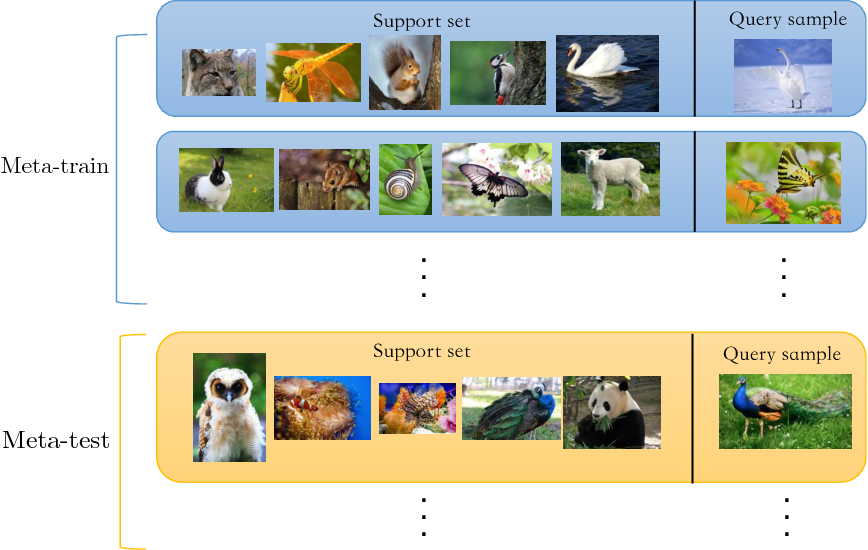

In [6]:
Image.open(os.path.join(data_path,"fs.png"))

There are different techniques to tackle few-shot classification with the most popular ones being:

    - gradient-based (Reptile)
    - metric-based (Prototypical networks)
    - memory-based

### Reptile
 
Gradient based approaches strive to find model weights during meta-learing for a base model which can be used for fine-tuning on novel tasks in meta-testing with the idea that the model converges very quickly with only few samples.

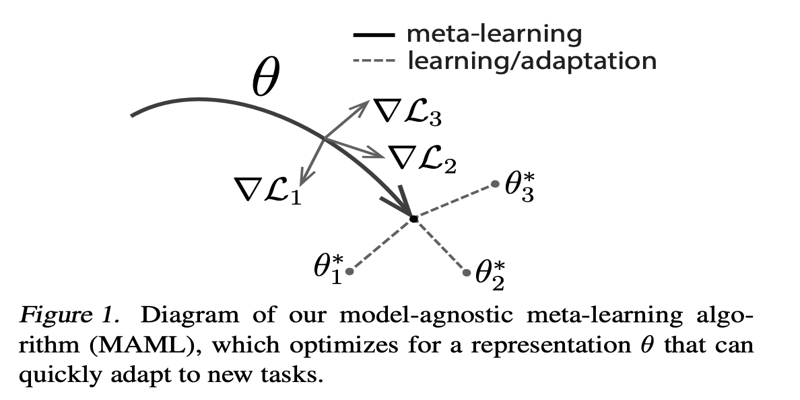

In [ ]:
Image.open(os.path.join(data_path,"maml.png")).resize((800,400))

Reptile:
    
    1. Get task from meta batch
    2. Train k steps on support data of task
    3. Compute difference between weights before and after step 2.
    4. Average for all tasks in meta-batch
    5. Update initial weights with ini+res*alpha

### ProtoFS

Metric based approaches typically define class prototypes based on the support samples in a metric space (e.g. euclidean space) and inference is done based on the class prototype which lies closest to the query instances.

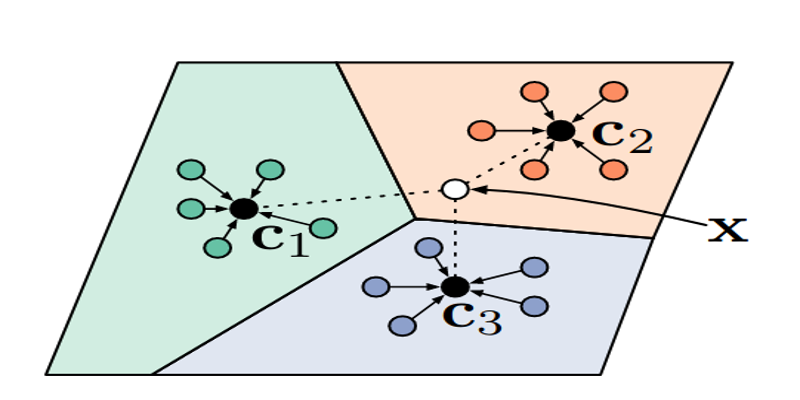

In [ ]:
Image.open(os.path.join(data_path,"proto.png")).resize((800,400))

ProtoFS Pseudo:

    1. For each task in meta batch:
    2. Compute support and query embeddings by running model
    3. Compute class prototypes by averaging support embeddings per class
    4. Calculate euclidean distance between each query embedding and prototype
    5. Prediction is closest class regarding the eucl. distance

## Exercise

Todays challenge is to implement [Reptile](https://arxiv.org/pdf/1803.02999.pdf) or [ProtoFS](https://arxiv.org/pdf/1703.05175.pdf). The goal is to achieve the highest accuracy on the meta-test set of the provided dataset Omniglot. The data pipeline and the base model are given. 

### Data
You are provided the meta-training data and the predictors of the meta-test for Omniglot, a dataset of handwritten characters. It contains 1623 different handwritten characters from 50 different alphabets. Each of the 1623 characters was drawn online via Amazon's Mechanical Turk by 20 different people. 964 Characters are given for meta-training, while the remaining characters are in meta-test. The setup is a 5-way 5-shot meaning each task contains 5 random characters with 5 labeled samples per class.

You will implement on of the two meta-learning techniques, and then create predictions for the 131 test tasks provided (with 25 = 5 classes * 5 shots per task). Save the predictions as a numpy file with shape (131,25) and upload as "pred_group-X.npy" on the learnweb. (Feel free to conduct your own train/val split on the training data, but you should train on the full meta-training data before predicting the test)

### Scores

At the end you will upload the final version for grading. The best performing group per approach gets 2 bonus points and the total best approach 1 more point.

In [3]:

import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid
import time

from omni import taskGen

In [4]:
meta_train = np.load(os.path.join(data_path,"data/omni_train.npy"))

In [5]:
meta_train.shape

(964, 20, 28, 28)

In [6]:
# If you want to experiment with train/val:
#meta_val   = meta_train[:250]
#meta_train = meta_train[250:]

In [7]:
class EncodingModel(tf.keras.Model):
    def __init__(self, num_classes=5, filters=16):
        super(EncodingModel, self).__init__()
        
        self.block1 = self.getConvBlock(filters)
        self.block2 = self.getConvBlock(filters)
        self.block3 = self.getConvBlock(filters)
        self.block4 = self.getConvBlock(filters)
        
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, x, training=True):
        
        x = self.block1(x,training=training)
        x = self.block2(x,training=training)
        x = self.block3(x,training=training)
        x = self.block4(x,training=training)

        x = self.flatten(x)
        
        return x
    
    def getConvBlock(self, filters):
        layers = [
        tf.keras.layers.Conv2D(filters, 3, strides=1, activation=None, padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU(),
        tf.keras.layers.MaxPool2D()]
        return tf.keras.Sequential(layers)

In [8]:
def pairwise_dist (A, B):  
  """
  Computes pairwise distances between each elements of A and each elements of B.
  Args:
    A,    [m,d] matrix
    B,    [n,d] matrix
  Returns:
    D,    [m,n] matrix of pairwise distances
  """

  # squared norms of each row in A and B
  na = tf.reduce_sum(tf.square(A), 1)
  nb = tf.reduce_sum(tf.square(B), 1)
  
  # na as a row and nb as a co"lumn vectors
  na = tf.reshape(na, [-1, 1])
  nb = tf.reshape(nb, [1, -1])

  # return pairwise euclidead difference matrix
  D = tf.sqrt(tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0))
  return D

In [9]:
# Hyperparamters for this experiment

# Fixed
NWAYS = 5
S_SHOTS = 5
Q_SHOTS = 5

# Changeable; These parameters give an okay performance if your meta-learning approach is set up correctly
# MB_SIZE = 5
MB_SIZE = 7 #TODO: change later
EPOCHS = 1000

# Reptile
outerstepsize = 0.1
innerstepsize = 0.1
innerepochs   = 5

# proto
learning_rate = 0.01
EPOCHS = 1000

In [27]:
class Model(tf.keras.Model):
    def __init__(self, encoder, loss, optimizer):
        super(Model, self).__init__()
        self.encoder = encoder
        self.loss = loss
        self.optimizer = optimizer
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')

    def proto_forward(self, sup_x, sup_y, que_x, training=False):
      results = []
      
      for i in range(len(sup_x)):
        # start of training episode:
        prototypes_k = []
      
        # print(i)

        for k in range(0, 5):
          per_class_idxes_sup = tf.where(sup_y[i]==k)
          # print("per_class_idxes_sup", per_class_idxes_sup)
          S_k = tf.gather(sup_x[i], per_class_idxes_sup)
          sup_y_k = tf.gather(sup_y[i], per_class_idxes_sup)
          
          # # select query examples per class k
          # per_class_idxes_q = tf.where(tf.equal(que_x[i],k))
          # Q_k = tf.gather(que_x[i], per_class_idxes_q)
          # print("Q_k shape:", Q_k.shape)

          # print("S_k shape:", S_k.shape)
          # print("sup_y_k shape:", sup_y_k.shape)
          
          # sup_embedings = self.encoder(sup_x[i])
          embeddings_k =[]
          for (x_i, y_i) in zip(S_k, sup_y_k):
            sup_embedings = self.encoder(x_i)
            embeddings_k.append(sup_embedings)
          
          c_k = tf.math.reduce_mean(embeddings_k, axis=0)
          # print("c_k shape:", c_k)
          
          # # # sup_one_hot = tf.one_hot(sup_y[i], NWAYS)
          # # sup_one_hot = tf.one_hot(sup_y_k, NWAYS)
          # # #print(sup_embedings.shape, sup_one_hot.shape)
          # prototypes = tf.transpose(sup_embedings) @ sup_one_hot
          # prototypes /= tf.reduce_sum(sup_one_hot,axis=0)
          prototypes_k.append(c_k)


      prototypes_k = tf.convert_to_tensor(prototypes_k)
      prototypes_k = tf.reshape(prototypes_k, (prototypes_k.shape[0], prototypes_k.shape[2]))
      print("prototypes_k shape:", prototypes_k.shape)

      
      for i in range(len(sup_x)):
        # start of training episode:
        que_embedings = self.encoder(que_x[i])
      
        # if training:
        #   for k in range(0, 5):
        #     # select query examples per class k
        #     per_class_idxes_q = tf.where(tf.equal(que_x[i],k))
        #     Q_k = tf.gather(que_x[i], per_class_idxes_q)
        #     print("Q_k shape:", Q_k.shape)
        #     # TODO: check this
        #     # que_embedings = self.encoder(que_x[i])
            # que_embedings = self.encoder(Q_k)
        
        # distances = pairwise_dist(tf.transpose(prototypes),que_embedings)
        # print("===here")
        # distances = pairwise_dist(tf.transpose(prototypes_k),que_embedings)
        distances = pairwise_dist(prototypes_k,que_embedings)
        # print("===here-------")

        results.append(tf.transpose(tf.nn.softmax(-distances,0)))
        
      return tf.stack(results)

    #@tf.function
    def train_step(self, sup_x, sup_y, que_x, que_y, NWAYS):
      with tf.GradientTape() as tape:
        loss = self.loss(que_y, self.proto_forward(sup_x, sup_y, que_x, training=True))
      gradients = tape.gradient(loss, self.encoder.trainable_variables)
      self.optimizer.apply_gradients(zip(gradients, self.encoder.trainable_variables))
      self.train_loss.update_state(loss)
      return loss

    '''
    @tf.function
    def test_step(self, x , y):
      predictions = self.model(x)
      loss = self.loss(y, predictions)
      self.test_loss.update_state(loss)
      return loss
    '''

    def train(self, train_gen, NWAYS):
      loss = []
      #idx = 0
      #while idx<10^100:
        #sup_x, sup_y, que_x, que_y = next(train_gen)
      for sup_x, sup_y, que_x, que_y in train_gen:
        loss.append(self.train_step(sup_x, sup_y, que_x, que_y, NWAYS))
        #break
      return loss
    
    '''
    def test(self):
      loss = []
      for bX, bY in self.test_ds:
        loss.append(self.test_step(bX, bY))  
      return loss 
    '''

    def run(self,meta_train, S_SHOTS, Q_SHOTS, NWAYS, MB_SIZE, epochs=25, verbose=2):
      history = []

      for i in range(epochs):
        train_gen = taskGen(meta_train, sup_shots=S_SHOTS, que_shots=Q_SHOTS, nways=NWAYS, meta_batchsize=MB_SIZE)

        train_loss = self.train(train_gen, NWAYS)

        history.append([train_loss])

        if verbose > 0 and (i==0 or (i+1)%5==0):
          print(f"epoch: {i+1}, TRAIN LOSS: {self.train_loss.result()}")
          

          self.train_loss.reset_states()

      return history

In [143]:
# sup_y

In [ ]:
model = Model(EncodingModel(NWAYS), tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), tf.keras.optimizers.Adam(learning_rate=0.01))
#model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#            optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
#            metrics="accuracy")



trainHist = model.run(meta_train, S_SHOTS, Q_SHOTS, NWAYS, MB_SIZE)

prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: (5, 16)
prototypes_k shape: 

In [105]:
sup_y.shape

(5, 25)

In [102]:
sup_y

array([[2, 2, 4, 4, 1, 0, 1, 3, 4, 2, 1, 2, 3, 3, 2, 4, 0, 3, 1, 0, 1, 0,
        3, 4, 0],
       [0, 2, 3, 2, 2, 4, 3, 3, 0, 1, 4, 4, 2, 0, 3, 0, 4, 2, 1, 1, 0, 1,
        1, 4, 3],
       [4, 0, 4, 3, 3, 4, 1, 0, 1, 4, 0, 3, 2, 3, 0, 4, 2, 1, 2, 2, 2, 3,
        0, 1, 1],
       [4, 2, 1, 3, 2, 3, 1, 3, 2, 1, 0, 4, 1, 2, 4, 4, 0, 2, 4, 3, 1, 0,
        3, 0, 0],
       [2, 2, 2, 1, 0, 3, 1, 2, 3, 4, 1, 0, 3, 4, 4, 0, 1, 3, 3, 2, 4, 4,
        0, 0, 1]])

In [121]:
sup_y[0][np.where(sup_y[0]==k)]

array([2, 2, 2, 2, 2])

In [104]:
sup_x.shape

(5, 25, 28, 28, 1)

In [91]:
k=2

tf.gather(sup_y[0], tf.where(tf.equal(sup_y[0],k)))

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[2],
       [2],
       [2],
       [2],
       [2]])>

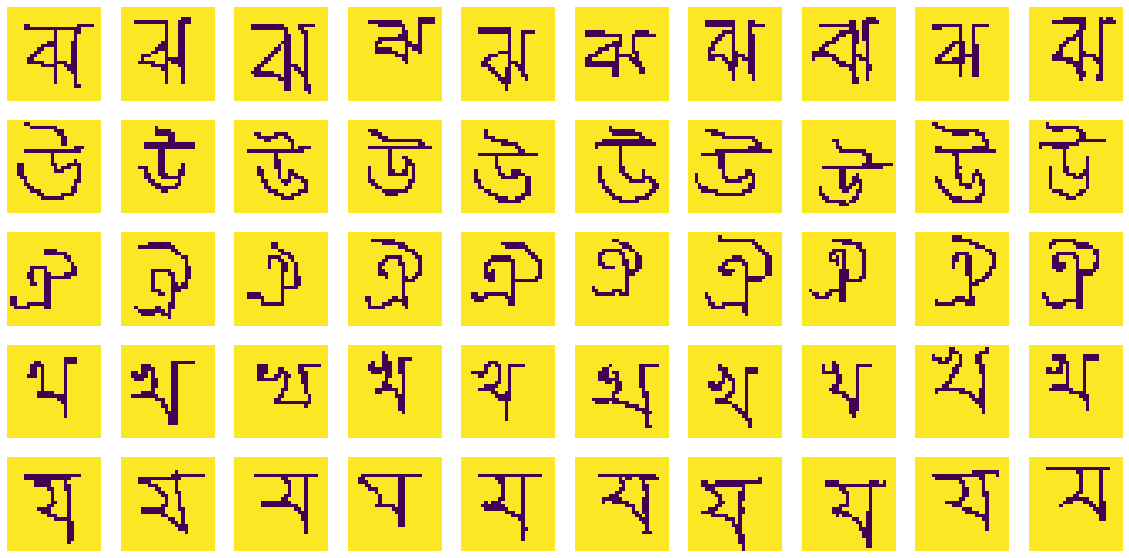

In [ ]:
# Visualization of omniglot images
fig = plt.figure(figsize=(20,10))
gs  = grid.GridSpec(5,10)

for i in range(5):
    
    for j in range(10):
    
        ax = plt.subplot(gs[i,j])
        ax.imshow(meta_train[i,j])
        plt.axis("off")

In [65]:
train_gen = taskGen(meta_train, sup_shots=S_SHOTS, que_shots=Q_SHOTS, nways=NWAYS, meta_batchsize=MB_SIZE)

# If you want to use a validation set
#val_gen = taskGen(meta_val, sup_shots=S_SHOTS, que_shots=Q_SHOTS, nways=NWAYS, meta_batchsize=MB_SIZE)

In [66]:
sup_x, sup_y, que_x, que_y = next(train_gen)
print("sup_x",sup_x.shape) 
print("sup_y",sup_y.shape) 
print("que_x",que_x.shape) 
print("que_y",que_y.shape)

sup_x (5, 25, 28, 28, 1)
sup_y (5, 25)
que_x (5, 25, 28, 28, 1)
que_y (5, 25)


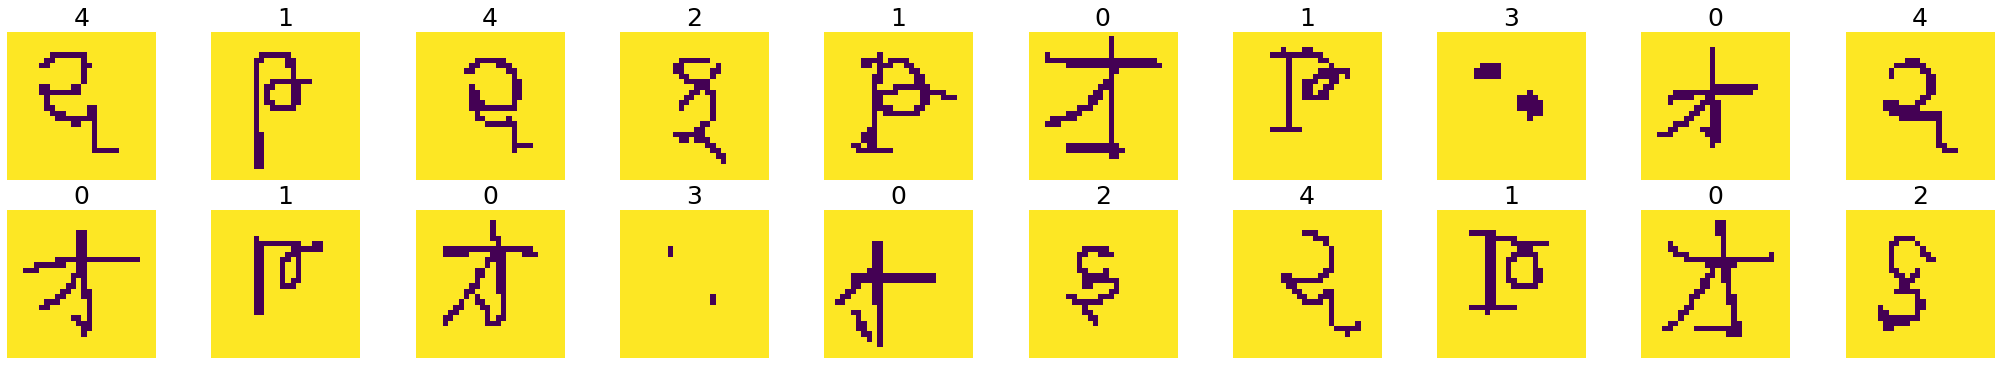

In [ ]:
fig = plt.figure(figsize=(36,6))
gs  = grid.GridSpec(2,10)

for i in range(10):
    
    ax = plt.subplot(gs[0,i])
    ax.imshow(sup_x[0,i,:,:,0])
    ax.set_title(sup_y[0,i],size=25)
    plt.axis("off")
    
    ax = plt.subplot(gs[1,i])
    ax.imshow(que_x[0,i,:,:,0])
    ax.set_title(que_y[0,i],size=25)
    plt.axis("off")

## Evaluate your approach

In [ ]:
# Predictors of the test data
test_que_x = np.load(os.path.join(data_path,"data/test_que_x.npy"))
test_sup_x = np.load(os.path.join(data_path,"data/test_sup_x.npy"))
test_sup_y = np.load(os.path.join(data_path,"data/test_sup_y.npy"))
print("sup_x",test_sup_x.shape) 
print("sup_y",test_sup_y.shape) 
print("que_x",test_que_x.shape) 

sup_x (131, 25, 28, 28, 1)
sup_y (131, 25)
que_x (131, 25, 28, 28, 1)


In [ ]:
# Eval

# if Reptile you want to save initial weights to reset before each task
#weights_init = model.get_weights()

preds = []
for t in range(len(test_que_x)):

    # if Reptile
    #model.set_weights(weights_init)
    
    sup_x, sup_y, que_x = test_sup_x[t], test_sup_y[t], test_que_x[t]#, test_que_y[t] , que_y
    
    pred = model.proto_forward(sup_x, sup_y, que_x)## Make prediction ##
        
    preds.append(np.argmax(pred,-1))

(28, 0) (5,)


InvalidArgumentError: ignored